# Recurrent Neural Networks

In [1400]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Time series forecasting

In [1401]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [1402]:
from pandas.tseries.offsets import MonthEnd

In [1403]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


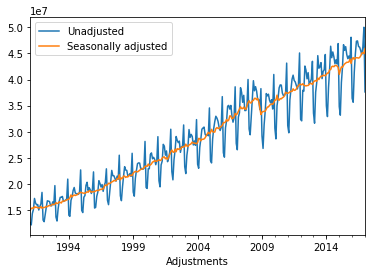

In [1404]:
df.plot()

In [1405]:
split_date = pd.Timestamp('01-01-2011')


In [1406]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

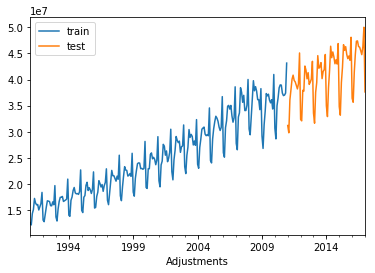

In [1407]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [1408]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [1409]:
train_sc[:4]


array([[ 0.01402033],
       [ 0.        ],
       [ 0.0704258 ],
       [ 0.09531795]])

In [1410]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

### Fully connected predictor

In [1411]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [1412]:
K.clear_session()
#compare with other optimizers
model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [1413]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [1414]:
#Try different bach sizes
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
239/239 [==============================] - 1s - loss: 0.1708     
Epoch 2/200
239/239 [==============================] - 0s - loss: 0.0351     
Epoch 3/200
239/239 [==============================] - 0s - loss: 0.0247     - ETA: 0s - loss
Epoch 4/200
239/239 [==============================] - 0s - loss: 0.0214     
Epoch 5/200
239/239 [==============================] - 0s - loss: 0.0184     
Epoch 6/200
239/239 [==============================] - 0s - loss: 0.0159     
Epoch 7/200
239/239 [==============================] - 0s - loss: 0.0140     
Epoch 8/200
239/239 [==============================] - 0s - loss: 0.0126     
Epoch 9/200
239/239 [==============================] - 0s - loss: 0.0117     
Epoch 10/200
239/239 [==============================] - 0s - loss: 0.0109     
Epoch 11/200
239/239 [==============================] - 0s - loss: 0.0105     
Epoch 12/200
239/239 [==============================] - 0s - loss: 0.0102     
Epoch 13/200
239/239 [=======================

In [1415]:
y_pred = model.predict(X_test)

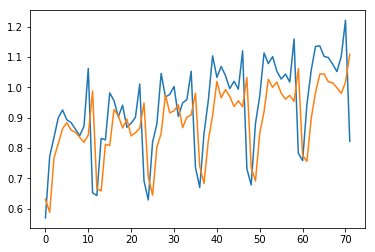

In [1416]:
plt.plot(y_test)
plt.plot(y_pred)

### Recurrent predictor

In [1417]:
from keras.layers import LSTM

In [1418]:
X_train.shape

(239, 1)

In [1419]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train[:, None].shape

(239, 1, 1)

In [1420]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [1421]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [1422]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
239/239 [==============================] - 5s - loss: 0.1029     
Epoch 2/100
239/239 [==============================] - ETA: 0s - loss: 0.032 - 3s - loss: 0.0321     
Epoch 3/100
239/239 [==============================] - 3s - loss: 0.0248     
Epoch 4/100
239/239 [==============================] - 3s - loss: 0.0194     
Epoch 5/100
239/239 [==============================] - 3s - loss: 0.0155     
Epoch 6/100
239/239 [==============================] - 3s - loss: 0.0127     
Epoch 7/100
239/239 [==============================] - 3s - loss: 0.0115     
Epoch 8/100
239/239 [==============================] - 3s - loss: 0.0105     
Epoch 9/100
239/239 [==============================] - 3s - loss: 0.0100     
Epoch 10/100
239/239 [==============================] - 3s - loss: 0.0100     
Epoch 11/100
239/239 [==============================] - 3s - loss: 0.0101     
Epoch 00010: early stopping


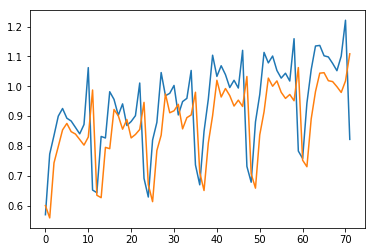

In [1423]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Windows

In [1424]:
train_sc.shape

(240, 1)

In [1425]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [1426]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [1427]:
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [1428]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [1429]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [1430]:
X_train.shape

(228, 12)

In [1431]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

### Experiment with Adam

In [1432]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)
X_train_t.shape
K.clear_session()
model = Sequential()
model.add(LSTM(6, input_shape=(1, 12)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [1433]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 6s - loss: 0.0211     
Epoch 2/100
228/228 [==============================] - 3s - loss: 0.0069     
Epoch 3/100
228/228 [==============================] - 3s - loss: 0.0064     
Epoch 4/100
228/228 [==============================] - 3s - loss: 0.0060     
Epoch 5/100
228/228 [==============================] - 3s - loss: 0.0052     
Epoch 6/100
228/228 [==============================] - 3s - loss: 0.0050     
Epoch 7/100
228/228 [==============================] - 3s - loss: 0.0046     
Epoch 8/100
228/228 [==============================] - 3s - loss: 0.0046     
Epoch 9/100
228/228 [==============================] - 3s - loss: 0.0040     
Epoch 10/100
228/228 [==============================] - 3s - loss: 0.0036     
Epoch 11/100
228/228 [==============================] - 3s - loss: 0.0035     
Epoch 12/100
228/228 [==============================] - 2s - loss: 0.0030     
Epoch 13/100
228/228 [==============================] - 3s - 

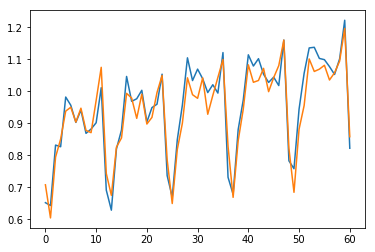

In [1434]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

### Experiment Using SGD

In [1435]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [1436]:
X_train_t.shape

(228, 1, 12)

In [1437]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='sgd')

In [1438]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [1439]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 3s - loss: 0.0451     
Epoch 2/100
228/228 [==============================] - 2s - loss: 0.0262     
Epoch 3/100
228/228 [==============================] - 2s - loss: 0.0206     
Epoch 4/100
228/228 [==============================] - 2s - loss: 0.0163     
Epoch 5/100
228/228 [==============================] - 2s - loss: 0.0132     
Epoch 6/100
228/228 [==============================] - 2s - loss: 0.0110     
Epoch 7/100
228/228 [==============================] - 2s - loss: 0.0094     
Epoch 8/100
228/228 [==============================] - 2s - loss: 0.0086     
Epoch 9/100
228/228 [==============================] - 2s - loss: 0.0079     
Epoch 10/100
228/228 [==============================] - 2s - loss: 0.0074     
Epoch 11/100
228/228 [==============================] - 2s - loss: 0.0073     
Epoch 12/100
228/228 [==============================] - 2s - loss: 0.0071     
Epoch 13/100
228/228 [==============================] - 2s - 

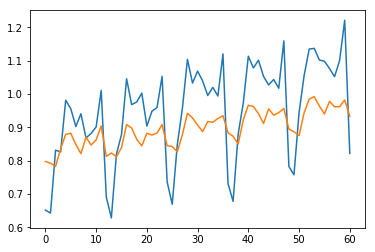

In [1440]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

# Experiment Using Adagrad


In [1441]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [1442]:
X_train_t.shape

(228, 1, 12)

In [1443]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [1444]:
K.clear_session()
model = Sequential()
model.add(LSTM(6, input_shape=(1, 12)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adagrad')

In [1445]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [1446]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [1447]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 4s - loss: 0.0164     
Epoch 2/100
228/228 [==============================] - 2s - loss: 0.0081     
Epoch 3/100
228/228 [==============================] - 2s - loss: 0.0073     
Epoch 4/100
228/228 [==============================] - 2s - loss: 0.0068     - E
Epoch 5/100
228/228 [==============================] - 2s - loss: 0.0066     
Epoch 6/100
228/228 [==============================] - 2s - loss: 0.0063     
Epoch 7/100
228/228 [==============================] - 2s - loss: 0.0062     
Epoch 8/100
228/228 [==============================] - 2s - loss: 0.0059     
Epoch 9/100
228/228 [==============================] - 2s - loss: 0.0058     
Epoch 10/100
228/228 [==============================] - 2s - loss: 0.0056     
Epoch 11/100
228/228 [==============================] - 2s - loss: 0.0055     
Epoch 12/100
228/228 [==============================] - 2s - loss: 0.0053     
Epoch 13/100
228/228 [==============================] - 2s

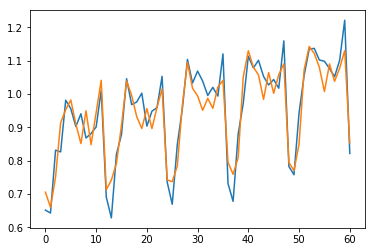

In [1448]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)